In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.video_classifier import VideoClassifier
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

In [4]:
class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 9, 9).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

In [5]:
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소
bands = 4 #밴드 수
patch_size = 9

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    patch_size = patch_size,
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file ="../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    patch_size = patch_size,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# 모델 설정
stage_repeats = [2, 2, 4, 3]  # 각 stage에서 ResBlock 반복 횟수
stage_channels = [16, 32, 64, 128]  # 각 stage의 채널 크기
num_classes = 6  # 분류할 클래스 개수

# 모델 생성
model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

Epoch 1/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.31it/s]



Epoch [1/30], Train Loss: 2.2032, Train Accuracy: 28.32%, Val Loss: 1.7388, Val Accuracy: 26.60%



Epoch 2/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.35it/s]



Epoch [2/30], Train Loss: 1.5618, Train Accuracy: 34.65%, Val Loss: 1.6105, Val Accuracy: 23.15%



Epoch 3/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [3/30], Train Loss: 1.3613, Train Accuracy: 42.21%, Val Loss: 1.3069, Val Accuracy: 39.01%



Epoch 4/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.41it/s]



Epoch [4/30], Train Loss: 1.1806, Train Accuracy: 50.98%, Val Loss: 0.9630, Val Accuracy: 56.94%



Epoch 5/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.33it/s]



Epoch [5/30], Train Loss: 0.8924, Train Accuracy: 64.13%, Val Loss: 0.7642, Val Accuracy: 65.45%



Epoch 6/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.34it/s]



Epoch [6/30], Train Loss: 0.7661, Train Accuracy: 68.74%, Val Loss: 0.6617, Val Accuracy: 73.66%



Epoch 7/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.39it/s]



Epoch [7/30], Train Loss: 0.7014, Train Accuracy: 71.92%, Val Loss: 0.6235, Val Accuracy: 74.26%



Epoch 8/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.32it/s]



Epoch [8/30], Train Loss: 0.6427, Train Accuracy: 74.46%, Val Loss: 0.5894, Val Accuracy: 75.13%



Epoch 9/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.34it/s]



Epoch [9/30], Train Loss: 0.6066, Train Accuracy: 76.23%, Val Loss: 0.5632, Val Accuracy: 78.15%



Epoch 10/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.33it/s]



Epoch [10/30], Train Loss: 0.5730, Train Accuracy: 77.59%, Val Loss: 0.5286, Val Accuracy: 78.73%



Epoch 11/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.44it/s]



Epoch [11/30], Train Loss: 0.5466, Train Accuracy: 78.93%, Val Loss: 0.5229, Val Accuracy: 80.00%



Epoch 12/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.41it/s]



Epoch [12/30], Train Loss: 0.5248, Train Accuracy: 79.86%, Val Loss: 0.5009, Val Accuracy: 81.47%



Epoch 13/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.43it/s]



Epoch [13/30], Train Loss: 0.5041, Train Accuracy: 80.80%, Val Loss: 0.4968, Val Accuracy: 81.29%



Epoch 14/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.48it/s]



Epoch [14/30], Train Loss: 0.4883, Train Accuracy: 81.54%, Val Loss: 0.4850, Val Accuracy: 82.51%



Epoch 15/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.44it/s]



Epoch [15/30], Train Loss: 0.4762, Train Accuracy: 82.03%, Val Loss: 0.4791, Val Accuracy: 82.85%



Epoch 16/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.44it/s]



Epoch [16/30], Train Loss: 0.4593, Train Accuracy: 82.70%, Val Loss: 0.4660, Val Accuracy: 83.05%



Epoch 17/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.42it/s]



Epoch [17/30], Train Loss: 0.4504, Train Accuracy: 83.13%, Val Loss: 0.4788, Val Accuracy: 83.12%



Epoch 18/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.42it/s]



Epoch [18/30], Train Loss: 0.4386, Train Accuracy: 83.53%, Val Loss: 0.4812, Val Accuracy: 83.24%



Epoch 19/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.43it/s]



Epoch [19/30], Train Loss: 0.4290, Train Accuracy: 83.99%, Val Loss: 0.4483, Val Accuracy: 83.88%



Epoch 20/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.45it/s]



Epoch [20/30], Train Loss: 0.4181, Train Accuracy: 84.48%, Val Loss: 0.4548, Val Accuracy: 83.40%



Epoch 21/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.31it/s]



Epoch [21/30], Train Loss: 0.4112, Train Accuracy: 84.75%, Val Loss: 0.4524, Val Accuracy: 83.86%



Epoch 22/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.38it/s]



Epoch [22/30], Train Loss: 0.4018, Train Accuracy: 85.15%, Val Loss: 0.4545, Val Accuracy: 83.95%



Epoch 23/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.46it/s]



Epoch [23/30], Train Loss: 0.3903, Train Accuracy: 85.55%, Val Loss: 0.4623, Val Accuracy: 84.25%



Epoch 24/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.45it/s]



Epoch [24/30], Train Loss: 0.3857, Train Accuracy: 85.95%, Val Loss: 0.4701, Val Accuracy: 83.17%



Epoch 25/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.42it/s]



Epoch [25/30], Train Loss: 0.3774, Train Accuracy: 86.27%, Val Loss: 0.4514, Val Accuracy: 84.72%



Epoch 26/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.45it/s]



Epoch [26/30], Train Loss: 0.3709, Train Accuracy: 86.44%, Val Loss: 0.4511, Val Accuracy: 84.71%



Epoch 27/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.37it/s]



Epoch [27/30], Train Loss: 0.3640, Train Accuracy: 86.69%, Val Loss: 0.4315, Val Accuracy: 84.89%



Epoch 28/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.42it/s]



Epoch [28/30], Train Loss: 0.3572, Train Accuracy: 87.01%, Val Loss: 0.4151, Val Accuracy: 85.59%



Epoch 29/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:54<00:00, 21.95it/s]



Epoch [29/30], Train Loss: 0.3520, Train Accuracy: 87.23%, Val Loss: 0.4570, Val Accuracy: 85.16%



Epoch 30/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.37it/s]



Epoch [30/30], Train Loss: 0.3445, Train Accuracy: 87.45%, Val Loss: 0.4313, Val Accuracy: 85.60%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3502/3502 [02:36<00:00, 22.38it/s]


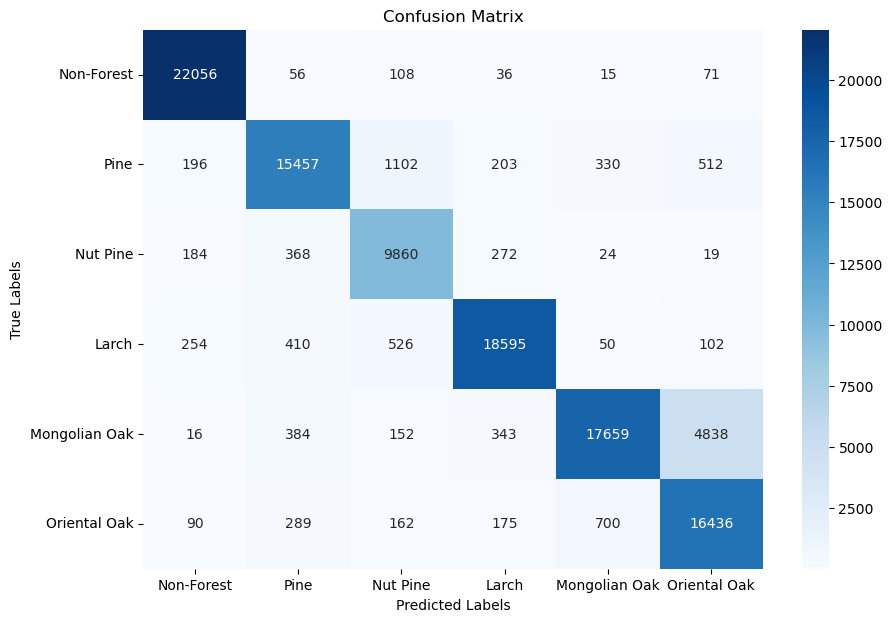

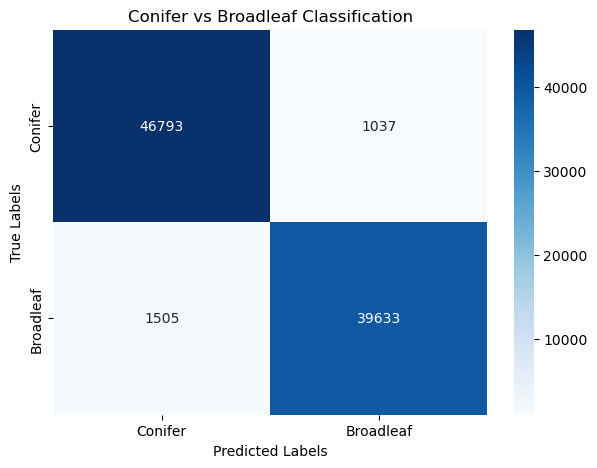

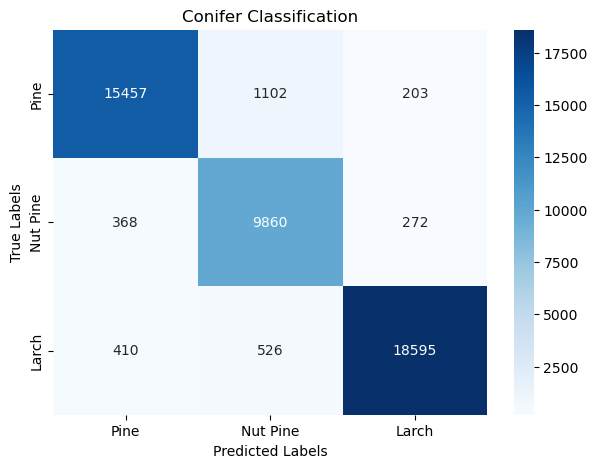

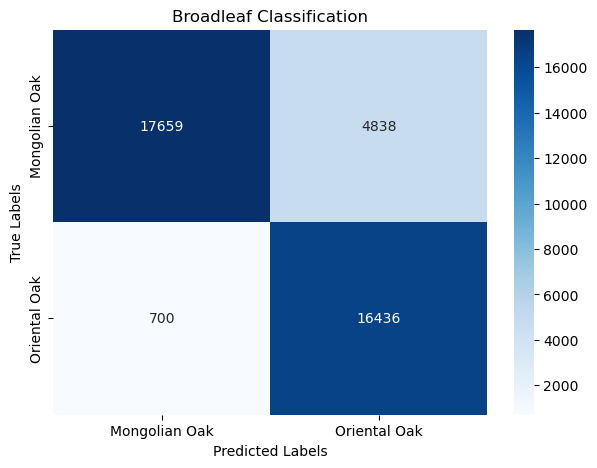


validation data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.32it/s]


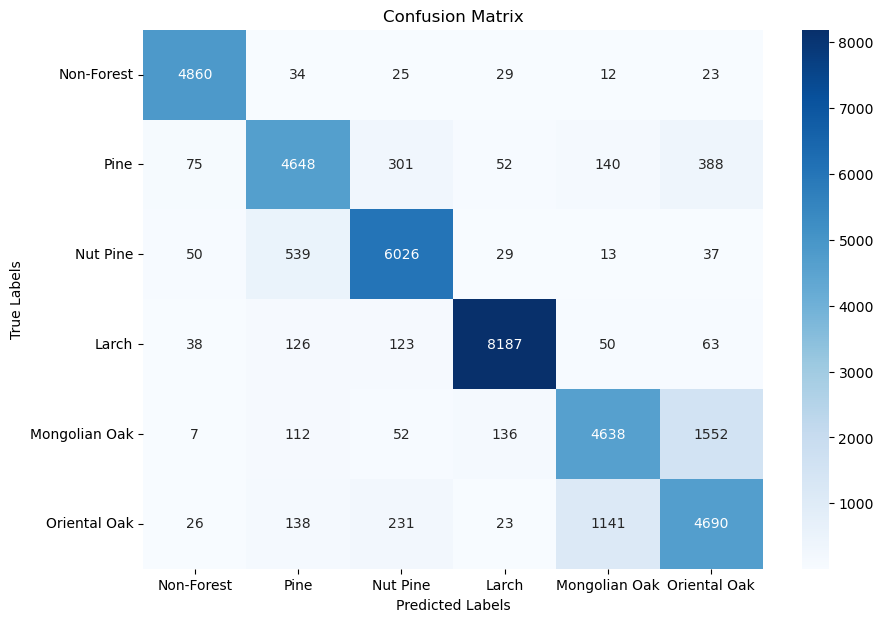

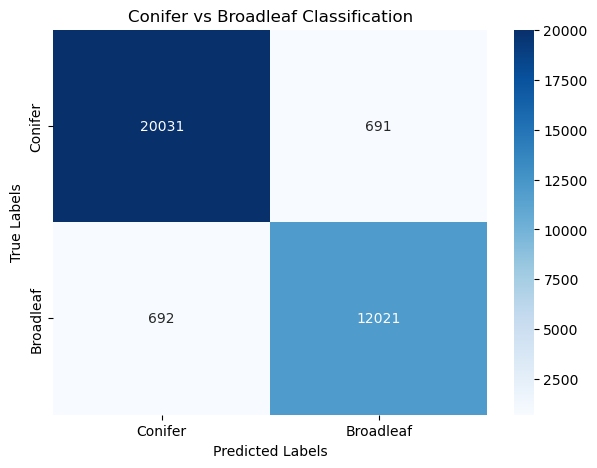

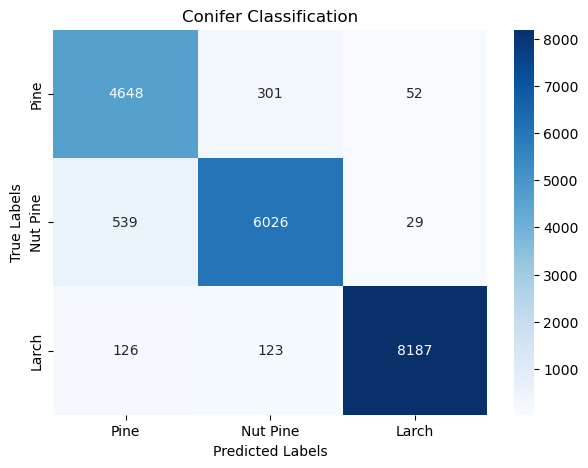

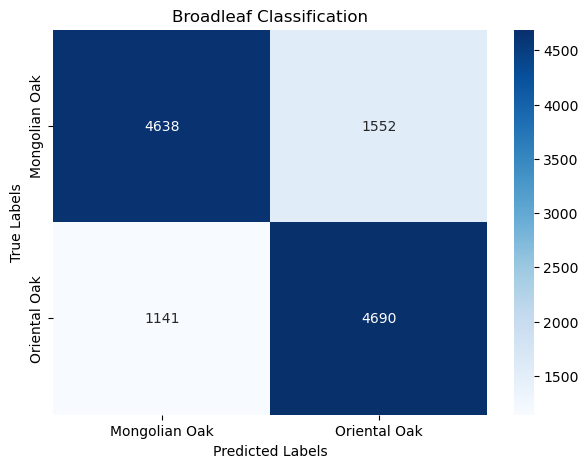

,precision,recall,f1-score,support,Category
Non-Forest,0.961234,0.975316,0.968224,4983.000000,Overall
Pine,0.830445,0.829408,0.829926,5604.000000,Overall
Nut Pine,0.891684,0.900209,0.895926,6694.000000,Overall
Larch,0.968188,0.953418,0.960746,8587.000000,Overall
Mongolian Oak,0.773774,0.713868,0.742615,6497.000000,Overall
Oriental Oak,0.694506,0.750520,0.721427,6249.000000,Overall
accuracy,0.855881,0.855881,0.855881,0.855881,Overall
macro avg,0.853305,0.853790,0.853144,38614.000000,Overall
weighted avg,0.857036,0.855881,0.856057,38614.000000,Overall
Conifer,0.966607,0.966654,0.966630,20722.000000,Conifer vs Broadleaf


In [7]:
num_epochs = 30

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
os.makedirs("./checkpoints/video_classification_enhanced", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/video_classification_enhanced/cnn_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.33it/s]



Epoch [1/20], Train Loss: 0.3514, Train Accuracy: 87.25%, Val Loss: 0.4613, Val Accuracy: 84.80%



Epoch 2/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [2/20], Train Loss: 0.3447, Train Accuracy: 87.58%, Val Loss: 0.4532, Val Accuracy: 85.24%



Epoch 3/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [3/20], Train Loss: 0.3373, Train Accuracy: 87.81%, Val Loss: 0.4349, Val Accuracy: 85.18%



Epoch 4/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.33it/s]



Epoch [4/20], Train Loss: 0.3329, Train Accuracy: 87.91%, Val Loss: 0.4358, Val Accuracy: 85.62%



Epoch 5/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.43it/s]



Epoch [5/20], Train Loss: 0.3299, Train Accuracy: 88.09%, Val Loss: 0.4329, Val Accuracy: 85.74%



Epoch 6/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.46it/s]



Epoch [6/20], Train Loss: 0.3201, Train Accuracy: 88.44%, Val Loss: 0.4272, Val Accuracy: 85.84%



Epoch 7/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.51it/s]



Epoch [7/20], Train Loss: 0.3167, Train Accuracy: 88.62%, Val Loss: 0.4252, Val Accuracy: 85.77%



Epoch 8/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.49it/s]



Epoch [8/20], Train Loss: 0.3117, Train Accuracy: 88.81%, Val Loss: 0.4506, Val Accuracy: 85.74%



Epoch 9/20 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.51it/s]



Epoch [9/20], Train Loss: 0.3085, Train Accuracy: 88.88%, Val Loss: 0.4357, Val Accuracy: 85.83%



Epoch 10/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.41it/s]



Epoch [10/20], Train Loss: 0.3051, Train Accuracy: 89.05%, Val Loss: 0.4052, Val Accuracy: 86.90%



Epoch 11/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.34it/s]



Epoch [11/20], Train Loss: 0.2967, Train Accuracy: 89.33%, Val Loss: 0.4413, Val Accuracy: 85.41%



Epoch 12/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.41it/s]



Epoch [12/20], Train Loss: 0.2970, Train Accuracy: 89.49%, Val Loss: 0.4217, Val Accuracy: 86.05%



Epoch 13/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.43it/s]



Epoch [13/20], Train Loss: 0.2890, Train Accuracy: 89.66%, Val Loss: 0.4117, Val Accuracy: 86.61%



Epoch 14/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.38it/s]



Epoch [14/20], Train Loss: 0.2879, Train Accuracy: 89.65%, Val Loss: 0.4028, Val Accuracy: 86.57%



Epoch 15/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.37it/s]



Epoch [15/20], Train Loss: 0.2832, Train Accuracy: 89.84%, Val Loss: 0.4135, Val Accuracy: 86.66%



Epoch 16/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.40it/s]



Epoch [16/20], Train Loss: 0.2772, Train Accuracy: 89.98%, Val Loss: 0.4102, Val Accuracy: 86.69%



Epoch 17/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.42it/s]



Epoch [17/20], Train Loss: 0.2747, Train Accuracy: 90.16%, Val Loss: 0.4063, Val Accuracy: 86.52%



Epoch 18/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.37it/s]



Epoch [18/20], Train Loss: 0.2718, Train Accuracy: 90.25%, Val Loss: 0.4122, Val Accuracy: 86.61%



Epoch 19/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.41it/s]



Epoch [19/20], Train Loss: 0.2681, Train Accuracy: 90.35%, Val Loss: 0.4088, Val Accuracy: 86.41%



Epoch 20/20 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.36it/s]



Epoch [20/20], Train Loss: 0.2643, Train Accuracy: 90.54%, Val Loss: 0.4323, Val Accuracy: 86.44%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3502/3502 [02:36<00:00, 22.39it/s]


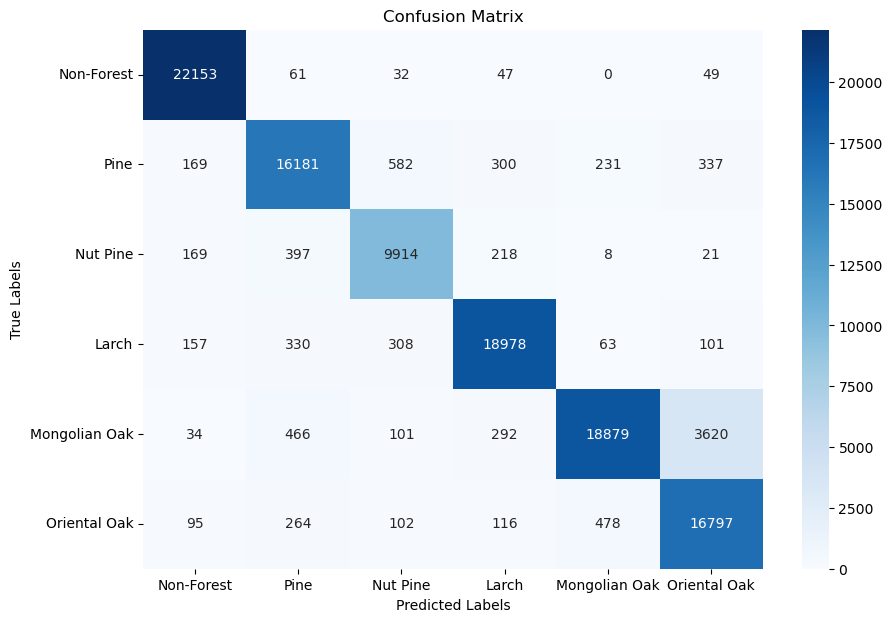

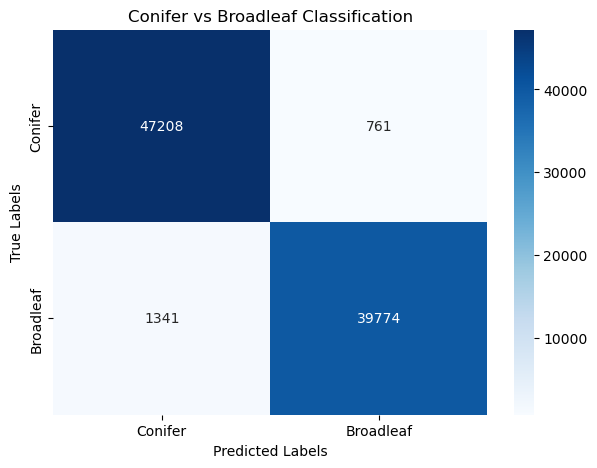

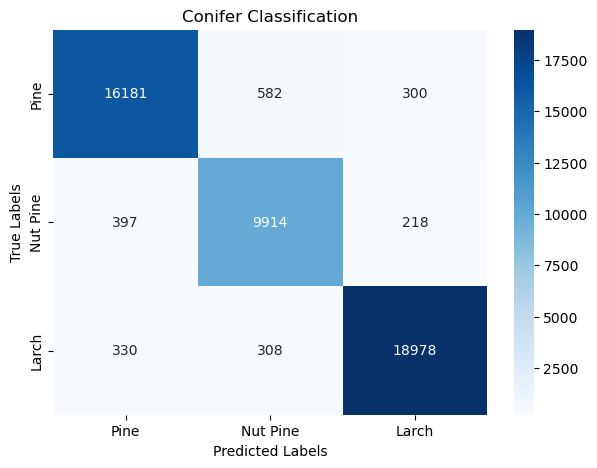

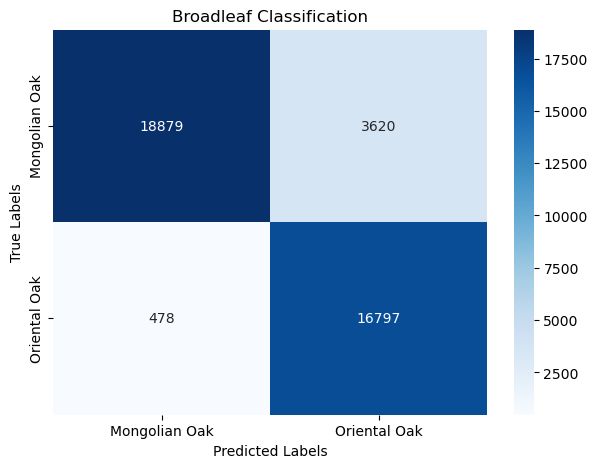


validation data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.38it/s]


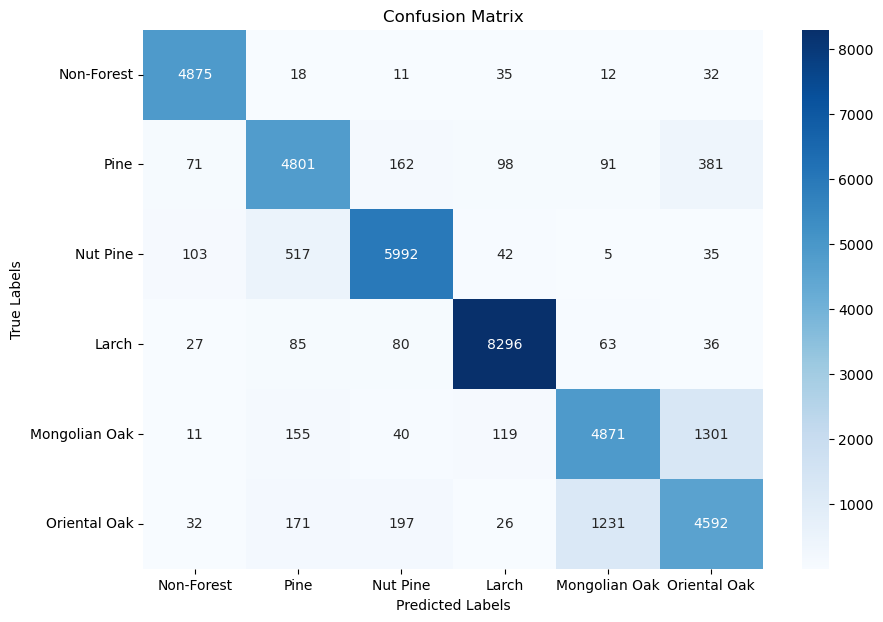

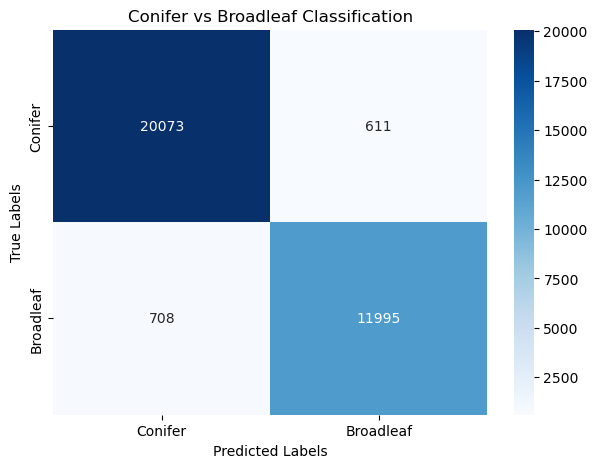

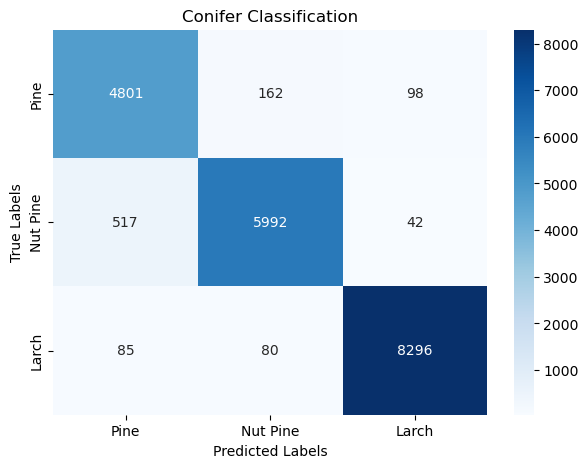

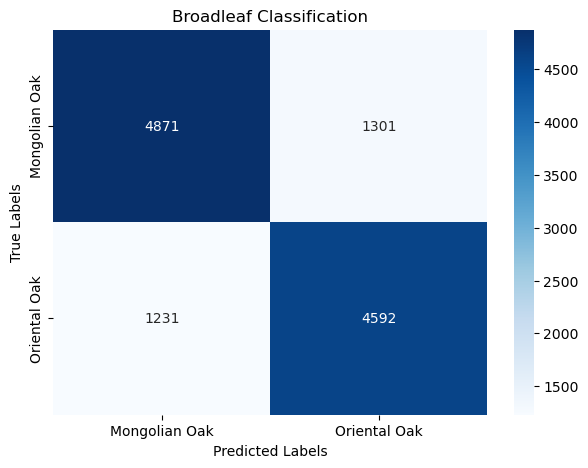

,precision,recall,f1-score,support,Category
Non-Forest,0.952334,0.978326,0.965155,4983.000000,Overall
Pine,0.835392,0.856709,0.845917,5604.000000,Overall
Nut Pine,0.924406,0.895130,0.909532,6694.000000,Overall
Larch,0.962860,0.966112,0.964483,8587.000000,Overall
Mongolian Oak,0.776502,0.749731,0.762882,6497.000000,Overall
Oriental Oak,0.720088,0.734838,0.727388,6249.000000,Overall
accuracy,0.865670,0.865670,0.865670,0.865670,Overall
macro avg,0.861930,0.863474,0.862560,38614.000000,Overall
weighted avg,0.865692,0.865670,0.865546,38614.000000,Overall
Conifer,0.965930,0.970460,0.968190,20684.000000,Conifer vs Broadleaf


In [8]:
num_epochs = 50

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=100)
os.makedirs("./checkpoints/video_classification_enhanced", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/video_classification_enhanced/cnn_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [7]:
model.load_state_dict(torch.load( "./checkpoints/video_classification_enhanced/cnn_4_9_50.pth",map_location=device))

<All keys matched successfully>

Epoch 1/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.51it/s]



Epoch [1/50], Train Loss: 0.2817, Train Accuracy: 89.86%, Val Loss: 0.4072, Val Accuracy: 86.73%



Epoch 2/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.50it/s]



Epoch [2/50], Train Loss: 0.2787, Train Accuracy: 89.97%, Val Loss: 0.4038, Val Accuracy: 86.46%



Epoch 3/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.38it/s]



Epoch [3/50], Train Loss: 0.2744, Train Accuracy: 90.06%, Val Loss: 0.4503, Val Accuracy: 85.75%



Epoch 4/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [4/50], Train Loss: 0.2712, Train Accuracy: 90.28%, Val Loss: 0.4469, Val Accuracy: 84.43%



Epoch 5/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.38it/s]



Epoch [5/50], Train Loss: 0.2667, Train Accuracy: 90.41%, Val Loss: 0.4240, Val Accuracy: 86.48%



Epoch 6/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.48it/s]



Epoch [6/50], Train Loss: 0.2635, Train Accuracy: 90.58%, Val Loss: 0.4281, Val Accuracy: 86.36%



Epoch 7/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [7/50], Train Loss: 0.2596, Train Accuracy: 90.72%, Val Loss: 0.4164, Val Accuracy: 86.43%



Epoch 8/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [8/50], Train Loss: 0.2591, Train Accuracy: 90.80%, Val Loss: 0.4182, Val Accuracy: 87.23%



Epoch 9/50 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.43it/s]



Epoch [9/50], Train Loss: 0.2558, Train Accuracy: 90.75%, Val Loss: 0.4413, Val Accuracy: 85.75%



Epoch 10/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.49it/s]



Epoch [10/50], Train Loss: 0.2488, Train Accuracy: 91.05%, Val Loss: 0.4078, Val Accuracy: 87.07%



Epoch 11/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.51it/s]



Epoch [11/50], Train Loss: 0.2487, Train Accuracy: 91.11%, Val Loss: 0.4347, Val Accuracy: 86.73%



Epoch 12/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.50it/s]



Epoch [12/50], Train Loss: 0.2458, Train Accuracy: 91.17%, Val Loss: 0.4543, Val Accuracy: 86.19%



Epoch 13/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [13/50], Train Loss: 0.2401, Train Accuracy: 91.35%, Val Loss: 0.4366, Val Accuracy: 86.45%



Epoch 14/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.54it/s]



Epoch [14/50], Train Loss: 0.2398, Train Accuracy: 91.43%, Val Loss: 0.4340, Val Accuracy: 87.07%



Epoch 15/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.56it/s]



Epoch [15/50], Train Loss: 0.2368, Train Accuracy: 91.46%, Val Loss: 0.4395, Val Accuracy: 86.46%



Epoch 16/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.58it/s]



Epoch [16/50], Train Loss: 0.2342, Train Accuracy: 91.63%, Val Loss: 0.4284, Val Accuracy: 86.96%



Epoch 17/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.56it/s]



Epoch [17/50], Train Loss: 0.2327, Train Accuracy: 91.66%, Val Loss: 0.4296, Val Accuracy: 86.45%



Epoch 18/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.54it/s]



Epoch [18/50], Train Loss: 0.2302, Train Accuracy: 91.67%, Val Loss: 0.4040, Val Accuracy: 87.40%



Epoch 19/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.49it/s]



Epoch [19/50], Train Loss: 0.2275, Train Accuracy: 91.89%, Val Loss: 0.4221, Val Accuracy: 87.14%



Epoch 20/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.56it/s]



Epoch [20/50], Train Loss: 0.2241, Train Accuracy: 92.03%, Val Loss: 0.4295, Val Accuracy: 87.10%



Epoch 21/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [21/50], Train Loss: 0.2227, Train Accuracy: 92.05%, Val Loss: 0.4231, Val Accuracy: 86.39%



Epoch 22/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [22/50], Train Loss: 0.2205, Train Accuracy: 92.23%, Val Loss: 0.4496, Val Accuracy: 86.34%



Epoch 23/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.50it/s]



Epoch [23/50], Train Loss: 0.2180, Train Accuracy: 92.12%, Val Loss: 0.4449, Val Accuracy: 86.89%



Epoch 24/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.51it/s]



Epoch [24/50], Train Loss: 0.2166, Train Accuracy: 92.31%, Val Loss: 0.4533, Val Accuracy: 86.93%



Epoch 25/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.56it/s]



Epoch [25/50], Train Loss: 0.2150, Train Accuracy: 92.35%, Val Loss: 0.4468, Val Accuracy: 86.19%



Epoch 26/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.53it/s]



Epoch [26/50], Train Loss: 0.2125, Train Accuracy: 92.42%, Val Loss: 0.4528, Val Accuracy: 86.80%



Epoch 27/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [27/50], Train Loss: 0.2114, Train Accuracy: 92.49%, Val Loss: 0.4507, Val Accuracy: 86.07%



Epoch 28/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.55it/s]



Epoch [28/50], Train Loss: 0.2103, Train Accuracy: 92.51%, Val Loss: 0.4236, Val Accuracy: 87.18%



Epoch 29/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.37it/s]



Epoch [29/50], Train Loss: 0.2083, Train Accuracy: 92.59%, Val Loss: 0.4428, Val Accuracy: 87.04%



Epoch 30/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.49it/s]



Epoch [30/50], Train Loss: 0.2069, Train Accuracy: 92.62%, Val Loss: 0.4815, Val Accuracy: 85.48%



Epoch 31/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.53it/s]



Epoch [31/50], Train Loss: 0.2052, Train Accuracy: 92.72%, Val Loss: 0.4714, Val Accuracy: 87.19%



Epoch 32/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.63it/s]



Epoch [32/50], Train Loss: 0.2037, Train Accuracy: 92.71%, Val Loss: 0.4475, Val Accuracy: 86.39%



Epoch 33/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.56it/s]



Epoch [33/50], Train Loss: 0.2012, Train Accuracy: 92.83%, Val Loss: 0.4310, Val Accuracy: 87.21%



Epoch 34/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.60it/s]



Epoch [34/50], Train Loss: 0.1984, Train Accuracy: 93.00%, Val Loss: 0.4570, Val Accuracy: 87.21%



Epoch 35/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.39it/s]



Epoch [35/50], Train Loss: 0.1959, Train Accuracy: 93.08%, Val Loss: 0.4500, Val Accuracy: 87.01%



Epoch 36/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [36/50], Train Loss: 0.1970, Train Accuracy: 93.03%, Val Loss: 0.4709, Val Accuracy: 87.17%



Epoch 37/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.62it/s]



Epoch [37/50], Train Loss: 0.1961, Train Accuracy: 92.93%, Val Loss: 0.4861, Val Accuracy: 87.30%



Epoch 38/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [38/50], Train Loss: 0.1922, Train Accuracy: 93.18%, Val Loss: 0.4940, Val Accuracy: 86.72%



Epoch 39/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.45it/s]



Epoch [39/50], Train Loss: 0.1914, Train Accuracy: 93.20%, Val Loss: 0.5505, Val Accuracy: 83.57%



Epoch 40/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.47it/s]



Epoch [40/50], Train Loss: 0.1914, Train Accuracy: 93.22%, Val Loss: 0.4339, Val Accuracy: 87.14%



Epoch 41/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.49it/s]



Epoch [41/50], Train Loss: 0.1886, Train Accuracy: 93.28%, Val Loss: 0.4436, Val Accuracy: 87.38%



Epoch 42/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.54it/s]



Epoch [42/50], Train Loss: 0.1892, Train Accuracy: 93.35%, Val Loss: 0.4625, Val Accuracy: 87.28%



Epoch 43/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.48it/s]



Epoch [43/50], Train Loss: 0.1859, Train Accuracy: 93.36%, Val Loss: 0.4267, Val Accuracy: 86.99%



Epoch 44/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.55it/s]



Epoch [44/50], Train Loss: 0.1863, Train Accuracy: 93.41%, Val Loss: 0.4729, Val Accuracy: 86.95%



Epoch 45/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [45/50], Train Loss: 0.1857, Train Accuracy: 93.37%, Val Loss: 0.4737, Val Accuracy: 86.43%



Epoch 46/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.43it/s]



Epoch [46/50], Train Loss: 0.1822, Train Accuracy: 93.54%, Val Loss: 0.5019, Val Accuracy: 86.38%



Epoch 47/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.56it/s]



Epoch [47/50], Train Loss: 0.1829, Train Accuracy: 93.38%, Val Loss: 0.4588, Val Accuracy: 87.09%



Epoch 48/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.57it/s]



Epoch [48/50], Train Loss: 0.1808, Train Accuracy: 93.52%, Val Loss: 0.4677, Val Accuracy: 87.72%



Epoch 49/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.45it/s]



Epoch [49/50], Train Loss: 0.1796, Train Accuracy: 93.56%, Val Loss: 0.4646, Val Accuracy: 86.02%



Epoch 50/50 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:53<00:00, 22.52it/s]



Epoch [50/50], Train Loss: 0.1797, Train Accuracy: 93.67%, Val Loss: 0.4485, Val Accuracy: 87.19%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3502/3502 [02:36<00:00, 22.43it/s]


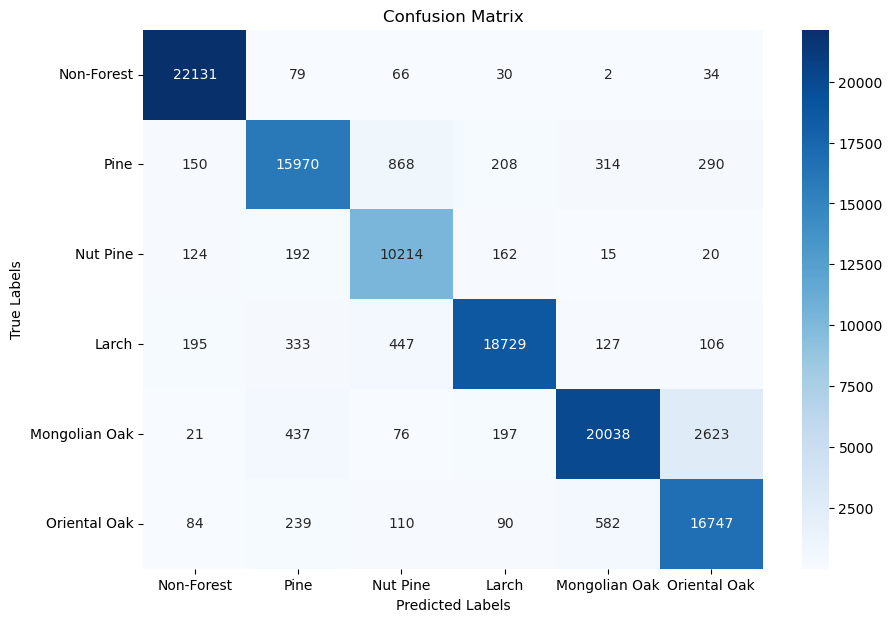

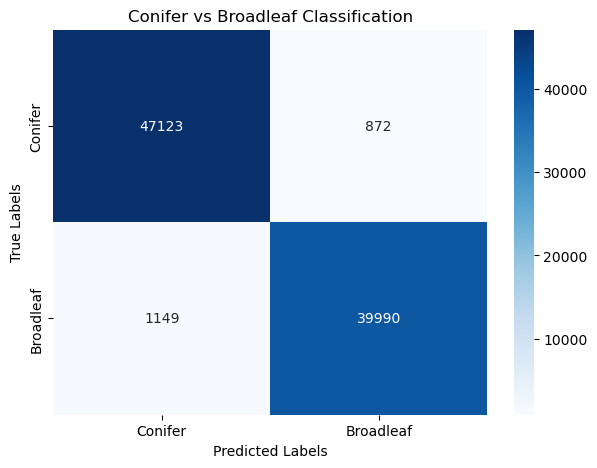

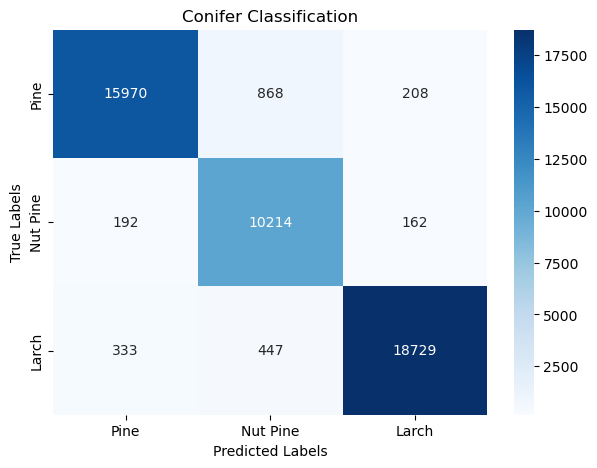

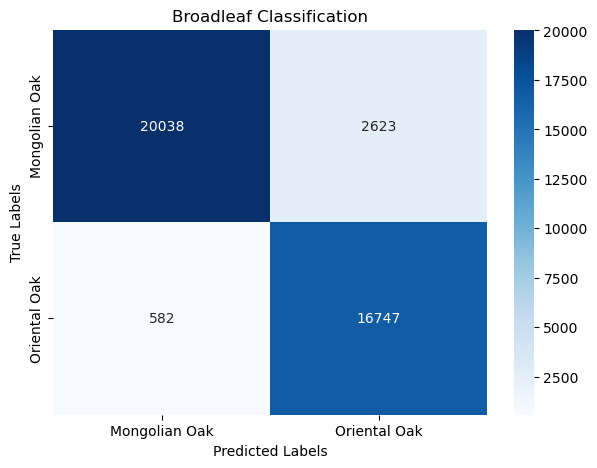


validation data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 1207/1207 [00:54<00:00, 22.32it/s]


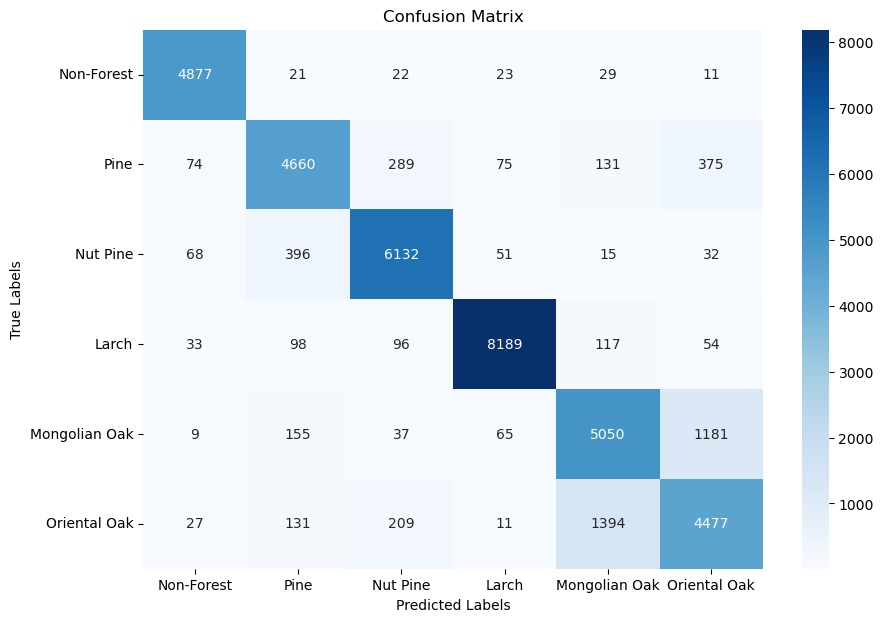

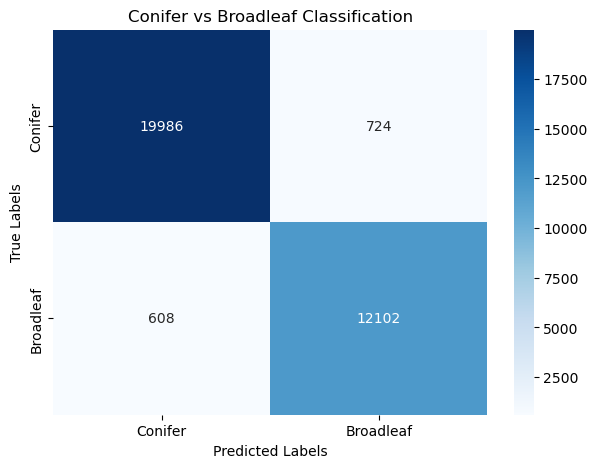

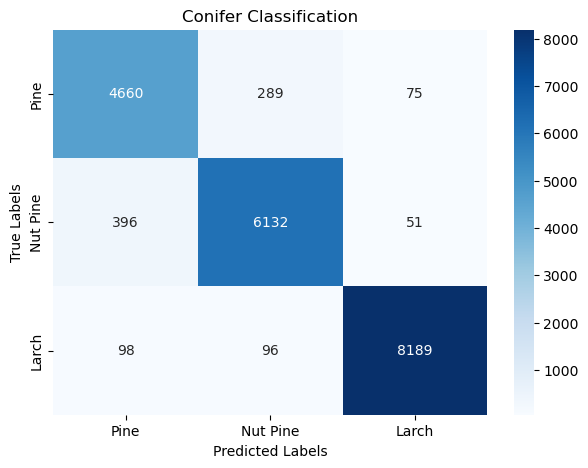

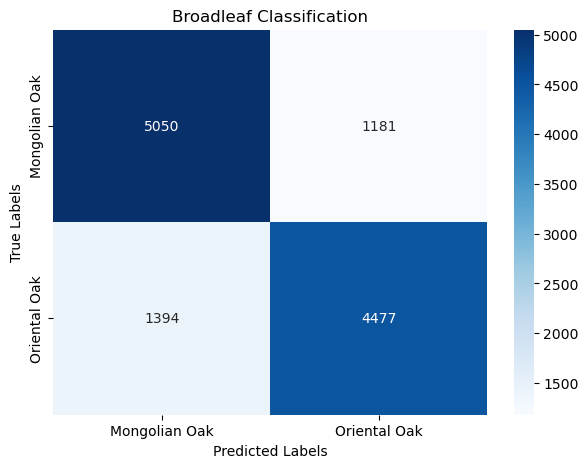

,precision,recall,f1-score,support,Category
Non-Forest,0.958530,0.978728,0.968523,4983.000000,Overall
Pine,0.853324,0.831549,0.842296,5604.000000,Overall
Nut Pine,0.903758,0.916044,0.909860,6694.000000,Overall
Larch,0.973259,0.953651,0.963355,8587.000000,Overall
Mongolian Oak,0.749703,0.777282,0.763243,6497.000000,Overall
Oriental Oak,0.730343,0.716435,0.723322,6249.000000,Overall
accuracy,0.864583,0.864583,0.864583,0.864583,Overall
macro avg,0.861486,0.862281,0.861767,38614.000000,Overall
weighted avg,0.864978,0.864583,0.864664,38614.000000,Overall
Conifer,0.970477,0.965041,0.967751,20710.000000,Conifer vs Broadleaf


In [8]:
num_epochs = 100

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=100)
os.makedirs("./checkpoints/video_classification_enhanced", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/video_classification_enhanced/cnn_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)